In [1]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 71 bytes


In [2]:
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d overratedgman/mammographic-mass-data-set

  0% 0.00/2.67k [00:00<?, ?B/s]
100% 2.67k/2.67k [00:00<00:00, 1.42MB/s]


In [4]:
!unzip mammographic-mass-data-set.zip

Archive:  mammographic-mass-data-set.zip
  inflating: Cleaned_data.csv        


In [5]:
import tensorflow
from tensorflow import keras
from keras import datasets
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, accuracy_score, classification_report, f1_score, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
from sklearn import neighbors
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC


In [6]:
#Load the dataset
data = pd.read_csv('Cleaned_data.csv')

In [7]:
print(data.shape)
print(data.info())
print(data.describe())

(830, 6)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 830 entries, 0 to 829
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   BI-RADS   830 non-null    int64
 1   Age       830 non-null    int64
 2   Shape     830 non-null    int64
 3   Margin    830 non-null    int64
 4   Density   830 non-null    int64
 5   Severity  830 non-null    int64
dtypes: int64(6)
memory usage: 39.0 KB
None
          BI-RADS         Age       Shape      Margin     Density    Severity
count  830.000000  830.000000  830.000000  830.000000  830.000000  830.000000
mean     4.393976   55.781928    2.781928    2.813253    2.915663    0.485542
std      1.888371   14.671782    1.242361    1.567175    0.350936    0.500092
min      0.000000   18.000000    1.000000    1.000000    1.000000    0.000000
25%      4.000000   46.000000    2.000000    1.000000    3.000000    0.000000
50%      4.000000   57.000000    3.000000    3.000000    3.000000    0.000000
7

In [8]:
#Check missing values
data.isnull().sum()

BI-RADS     0
Age         0
Shape       0
Margin      0
Density     0
Severity    0
dtype: int64

In [10]:
col_list = ['BI-RADS', 'Age', 'Shape', 'Margin', 'Density', 'Severity']

In [11]:
#Look into values of columns
for i in col_list:
  print(data[i].value_counts(), '\n')

4     468
5     316
3      24
6       9
2       7
0       5
55      1
Name: BI-RADS, dtype: int64 

67    30
59    29
66    28
57    27
46    25
      ..
88     1
93     1
26     1
18     1
20     1
Name: Age, Length: 72, dtype: int64 

4    379
1    190
2    180
3     81
Name: Shape, dtype: int64 

1    320
4    254
5    127
3    106
2     23
Name: Margin, dtype: int64 

3    755
2     56
1     11
4      8
Name: Density, dtype: int64 

0    427
1    403
Name: Severity, dtype: int64 



In [12]:
#BI-RADS have values 55 and 6 which are not in BI-RADS scale[1-5]

In [13]:
idx = data[data['BI-RADS'] == 55].index
print(idx)

Int64Index([257], dtype='int64')


In [14]:
idx = data[data['BI-RADS'] == 6].index
print(idx)

Int64Index([441, 545, 569, 584, 594, 595, 657, 703, 759], dtype='int64')


In [15]:
#Delete wrong records
data = data.drop([257, 441, 545, 569, 584, 594, 595, 657, 703, 759],axis=0)
data = data.reset_index(drop=True)

In [16]:
data.shape

(820, 6)

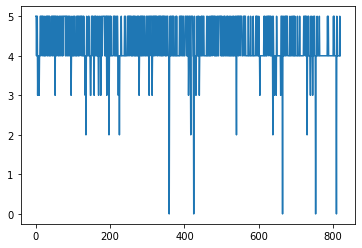

In [17]:
#Check distribution of BI-RADS
plt.plot(data['BI-RADS'])

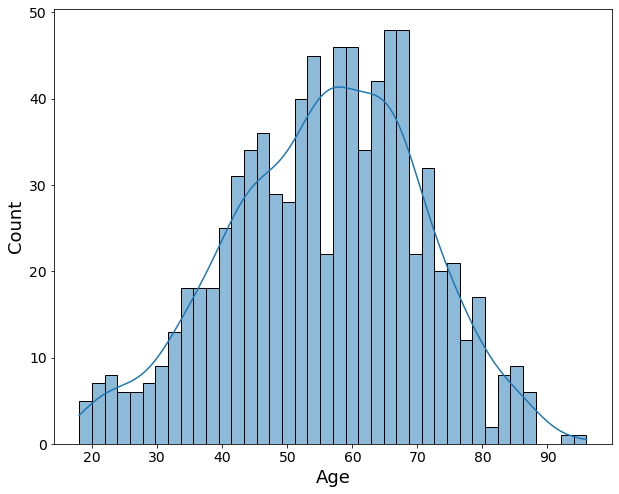

In [18]:
#Plot frequency histogram of age
fig, axes = plt.subplots(1, 1, figsize=(10, 8))
sns.histplot(x="Age", kde=True, data=data, ax=axes, bins=40);
axes.set(xlabel="Age");
axes.xaxis.label.set_size(18)
axes.yaxis.label.set_size(18)
axes.tick_params('y', labelsize = 14);
axes.tick_params('x', labelsize = 14);

In [19]:
#'Shape' and 'Margin' are categorical so I have to convert them to indicator variables
categorical_cols = ['Shape', 'Margin']
data = pd.get_dummies(data, columns = categorical_cols, drop_first=True)

In [20]:
print(data.shape)
print(data.info())
print(data.describe())

(820, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 820 entries, 0 to 819
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   BI-RADS   820 non-null    int64
 1   Age       820 non-null    int64
 2   Density   820 non-null    int64
 3   Severity  820 non-null    int64
 4   Shape_2   820 non-null    uint8
 5   Shape_3   820 non-null    uint8
 6   Shape_4   820 non-null    uint8
 7   Margin_2  820 non-null    uint8
 8   Margin_3  820 non-null    uint8
 9   Margin_4  820 non-null    uint8
 10  Margin_5  820 non-null    uint8
dtypes: int64(4), uint8(7)
memory usage: 31.4 KB
None
          BI-RADS         Age     Density    Severity     Shape_2     Shape_3  \
count  820.000000  820.000000  820.000000  820.000000  820.000000  820.000000   
mean     4.314634   55.739024    2.915854    0.481707    0.218293    0.096341   
std      0.669248   14.684062    0.351508    0.499970    0.413339    0.295239   
min      0.000000   18.000

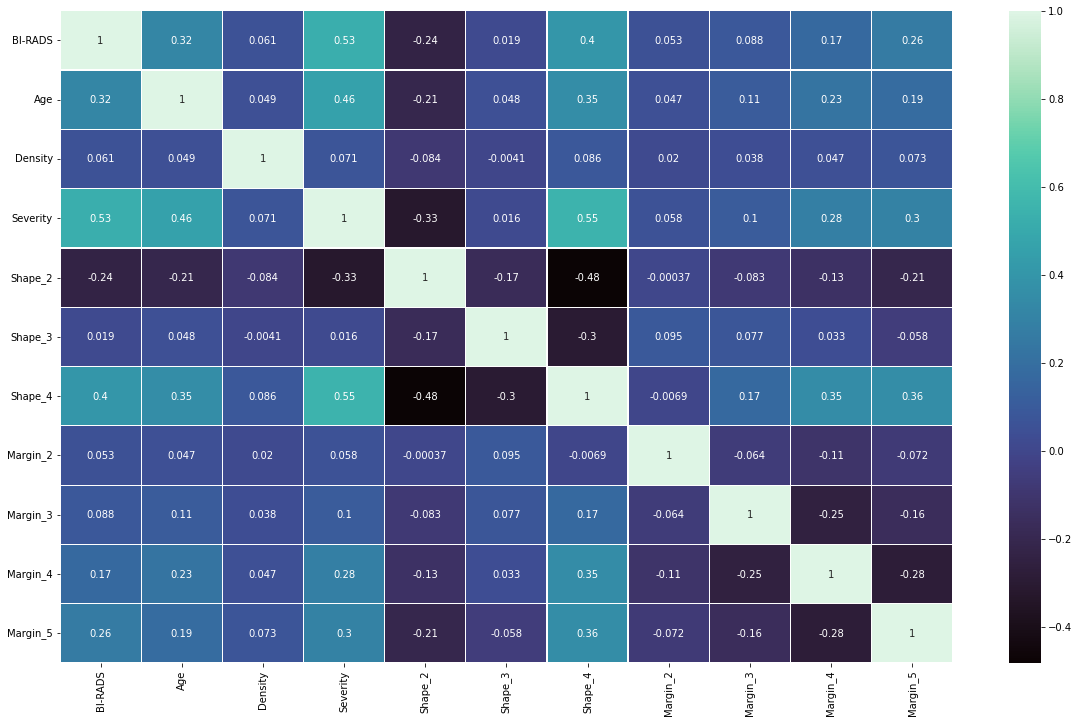

In [21]:
#Correlation between columns
sns.heatmap(data.corr(),annot=True,cmap='mako',linewidths=0.2)
fig=plt.gcf()
fig.set_size_inches(20,12)
plt.show()

In [22]:
X = data.drop(columns=['Severity'],axis=1)
y = data['Severity']

In [23]:
#Splitting dataset
X_train, x_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

In [24]:
#Using StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)  
x_test = scaler.transform(x_test)

In [25]:
print(X_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(656, 10) (656,)
(164, 10) (164,)


In [26]:
#Create a model
model = Sequential()

model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                704       
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 32)                2

In [28]:
history = model.fit(X_train, y_train, 
                    batch_size=10, epochs=30, verbose=True, 
                    validation_data=(x_test, y_test))

Epoch 1/30
66/66 [==============================] - 1s 6ms/step - loss: 0.6458 - accuracy: 0.6616 - val_loss: 0.4914 - val_accuracy: 0.8293
Epoch 2/30
66/66 [==============================] - 0s 4ms/step - loss: 0.4959 - accuracy: 0.7881 - val_loss: 0.4218 - val_accuracy: 0.8232
Epoch 3/30
66/66 [==============================] - 0s 4ms/step - loss: 0.4562 - accuracy: 0.8018 - val_loss: 0.4264 - val_accuracy: 0.8293
Epoch 4/30
66/66 [==============================] - 0s 3ms/step - loss: 0.4441 - accuracy: 0.8095 - val_loss: 0.4195 - val_accuracy: 0.8232
Epoch 5/30
66/66 [==============================] - 0s 4ms/step - loss: 0.4115 - accuracy: 0.8308 - val_loss: 0.4287 - val_accuracy: 0.8171
Epoch 6/30
66/66 [==============================] - 0s 4ms/step - loss: 0.4266 - accuracy: 0.8232 - val_loss: 0.4380 - val_accuracy: 0.8354
Epoch 7/30
66/66 [==============================] - 0s 4ms/step - loss: 0.4190 - accuracy: 0.8430 - val_loss: 0.4373 - val_accuracy: 0.8293
Epoch 8/30
66/66 [==

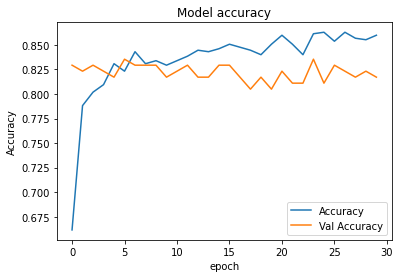

In [29]:
plt.plot(history.history['accuracy'], label= 'Accuracy')
plt.plot(history.history['val_accuracy'], label= 'Val Accuracy')

plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()

In [30]:
model.evaluate(x_test, y_test)

6/6 [==============================] - 0s 3ms/step - loss: 0.4934 - accuracy: 0.8171


[0.4934290945529938, 0.8170731663703918]

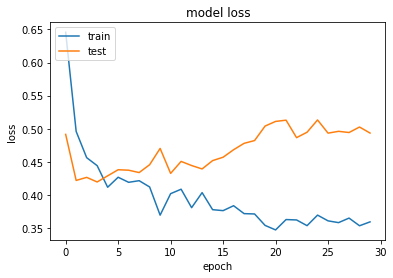

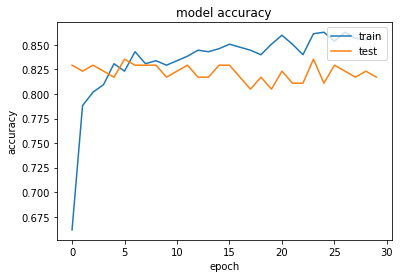

In [31]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# # summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [32]:
model.save('model.h5')

In [33]:
#Checking classification models

In [34]:
reg = MLPClassifier(max_iter=1000, hidden_layer_sizes=(5,5), random_state=1)
reg.fit(X_train, y_train)
y_pred = reg.predict(x_test)
accuracy_score(y_pred,y_test)

0.823170731707317

In [35]:
clf_dtc = DecisionTreeClassifier(random_state= 42)
clf_dtc.fit(X_train, y_train)
y_pred = clf_dtc.predict(x_test)
accuracy_score(y_pred, y_test)

0.7865853658536586

In [36]:
clf_svc = SVC(C = 1.0, kernel = 'linear')
clf_svc.fit(X_train, y_train)
y_pred = clf_svc.predict(x_test)
accuracy_score(y_pred, y_test)

0.7987804878048781

In [37]:
clf_lr = LogisticRegression()
clf_lr.fit(X_train, y_train)
y_pred = clf_lr.predict(x_test)
accuracy_score(y_pred, y_test)

0.8170731707317073

In [38]:
clf_knn = neighbors.KNeighborsClassifier(n_neighbors=10)
clf_knn.fit(X_train, y_train)
y_pred = clf_knn.predict(x_test)
accuracy_score(y_pred, y_test)

0.7865853658536586

In [39]:
clf_rfc = RandomForestClassifier(n_estimators=2)
clf_rfc.fit(X_train, y_train)
y_pred = clf_rfc.predict(x_test)
accuracy_score(y_pred, y_test)

0.7621951219512195

In [41]:
#The best results were obtained by Multi-layer Perceptron classifier

0.8304093567251463

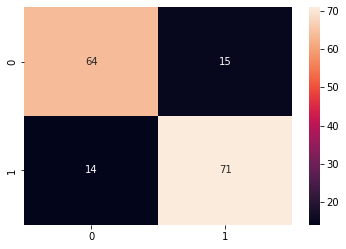

In [42]:
#Confusion matrix for MLP Classifier
sns.heatmap(confusion_matrix(reg.predict(x_test), y_test),annot=True)
f1_score(reg.predict(x_test), y_test)